In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import math as mt
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import re

In [2]:
def data_load():	
    costs_dl = pd.read_csv(
	    'costs_us.csv', 
	    dtype={'source_id': 'category'}, 
	    parse_dates=['dt'], 
	    # nrows=500
	    )
    #
    orders_dl = pd.read_csv(
	    'orders_log_us.csv',
	    parse_dates = ['Buy Ts'],
	    # nrows = 500
	)
    orders_dl.columns = ['buy_ts', 'revenue', 'uid']
    #
    visits_dl = pd.read_csv(
	    'visits_log_us.csv',
	    dtype={'Device': 'category', 'Source Id': 'int'}, 
	    parse_dates = ['End Ts', 'Start Ts'],
	    # nrows = 500
	)
    visits_dl.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
    return costs_dl, orders_dl, visits_dl

In [3]:
def data_prep(device, visits, orders, costs_us, filter = False):

	# visits.info()
	if filter:
		visits = visits.merge(orders, on= 'uid', how= 'inner')
		
	else:
		visits = orders
		device = 'General'
	#
	visits['order_month'] = pd.to_datetime(visits['buy_ts'], format="%Y-%m").dt.date
	visits['order_month'] = pd.to_datetime(visits['order_month'], format="%Y-%m")
	visits['order_month'] = visits['order_month'].dt.strftime('%Y-%m')
	visits['order_month'] = pd.to_datetime(visits['order_month'], format="%Y-%m")
	#
	if filter:
		visits = visits[visits['device'] == device][['buy_ts','revenue', 'uid', 'order_month']]
		visits = visits.drop_duplicates()
	#
	first_orders = visits.groupby('uid').agg({'order_month': 'min'}).reset_index()
	first_orders.columns = ['uid', 'first_order_month']
	#
	cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
	cohort_sizes.columns = ['first_order_month', 'n_buyers']
	#
	orders_ = pd.merge(visits,first_orders, on='uid')
	#
	cohorts = orders_.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
	#
	report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
	report['first_order_month'] =  pd.to_datetime(report['first_order_month'], format="%Y-%m")
	#
	margin_rate = 0.5
	#
	report['gp'] = report['revenue'] * margin_rate
	report['age'] = (
	    report['order_month'] - report['first_order_month']
	) / np.timedelta64(1, 'D') / 30
	report['age'] = report['age'].round().astype('int')
	#
	report['ltv'] = report['gp'] / report['n_buyers']
	#
	costs_us['month'] = costs_us['dt'].dt.strftime('%Y-%m')
	#
	costs_time = costs_us.groupby(['source_id','month'], observed= False).agg({'costs' : 'sum'}).reset_index()
	costs_time['month'] = pd.to_datetime(costs_time['month'], format="%Y-%m")
	#
	sources = costs_time['source_id'].unique()#.astype('str')
	#
	costs_us['month'] = pd.to_datetime(costs_us['month'], format="%Y-%m")

	return report, costs_time, sources, visits, orders, costs_us, device


In [4]:
def marketing_metrics(costs, source, report, case = 1, pnt = False):
    df = costs[costs['source_id'] == source][['month', 'costs']]
    report_ = report.merge(df, left_on='first_order_month', right_on='month', how='inner')
    report_ = report_.drop_duplicates()
    report_['cac'] = report_['costs'] / report_['n_buyers']
    
    report_['romi'] = report_['ltv'] / report_['cac']
    output = report_.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean')
    if(case == 1):
        if(pnt):
            print(report_)
        return report_
    if( case == 2):
        if(pnt):
            print(output)
        return output

In [5]:
def filter_name(filter = 0):
    if filter == 'desktop':
        return 'Desktop'
    elif filter == 'touch':
        return 'Touch'
    else:
        return 'No_filter'

['touch', 'desktop']
Categories (2, object): ['desktop', 'touch'] 

               buy_ts  revenue                   uid order_month
0 2018-03-09 20:25:00     2.33  16174680259334210214  2018-03-01
1 2017-09-04 12:46:00     2.44  16007536194108375387  2017-09-01
2 2017-10-28 00:01:00     1.53  16007536194108375387  2017-10-01
3 2017-10-28 19:16:00     1.53  16007536194108375387  2017-10-01
4 2017-06-25 08:54:00     3.67   8056418121947262981  2017-06-01


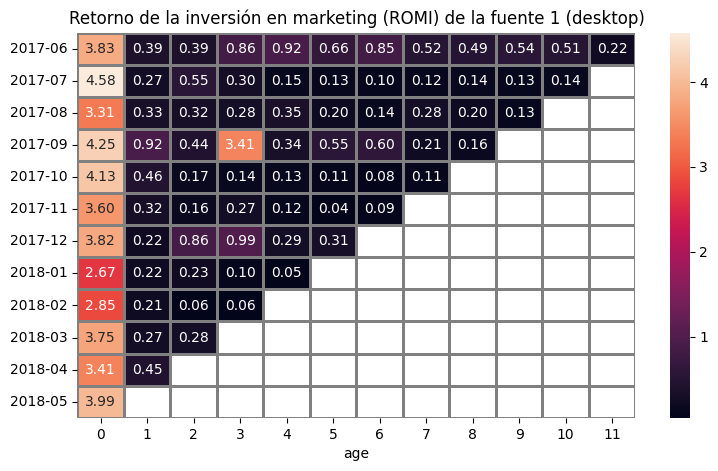

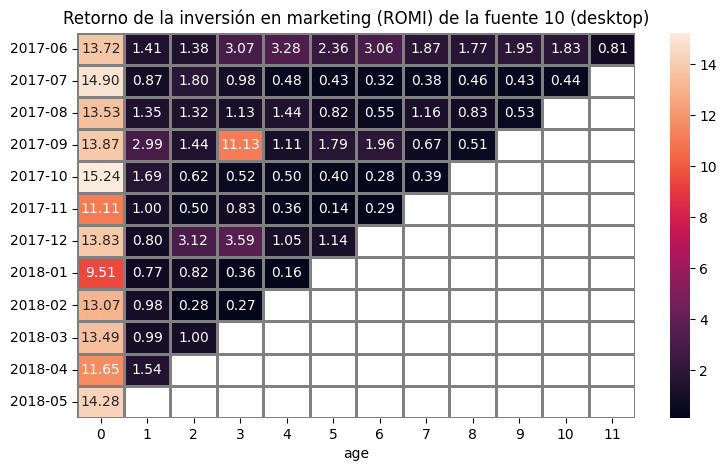

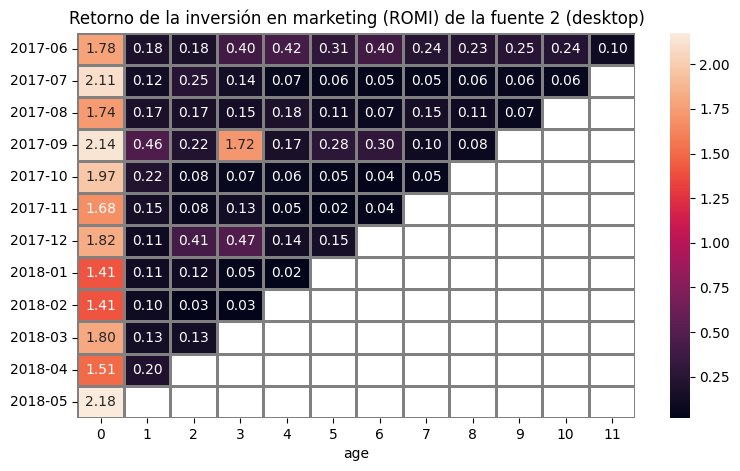

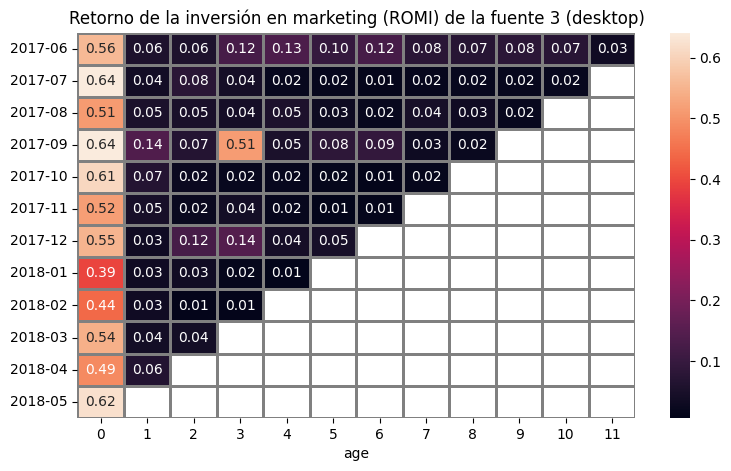

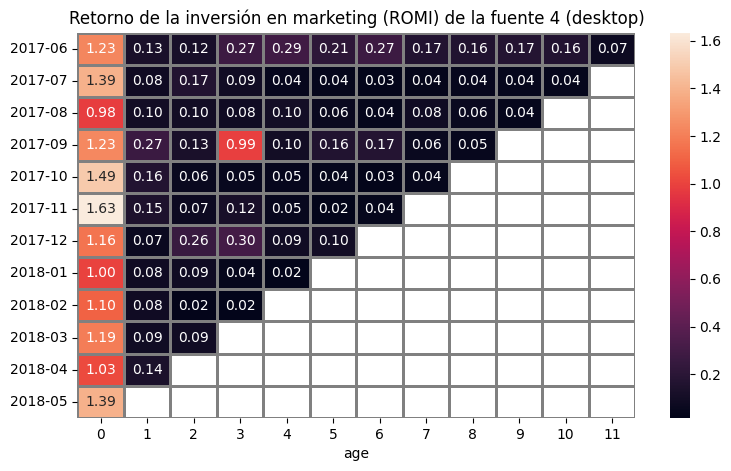

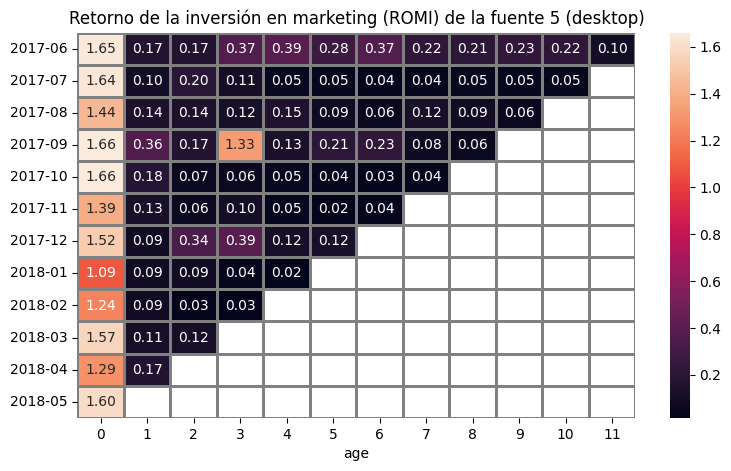

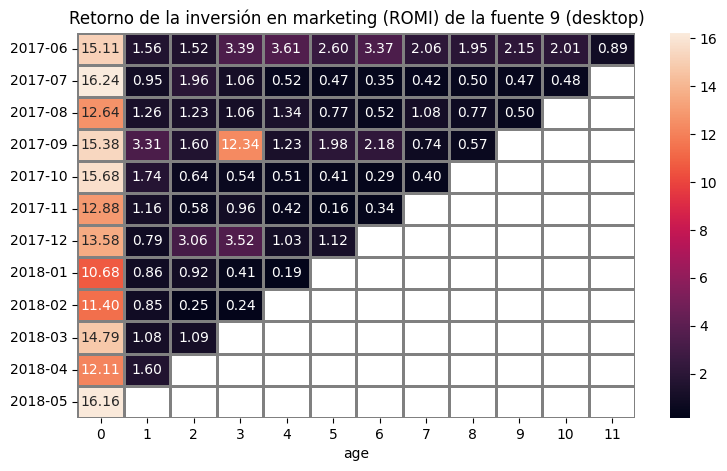

In [6]:
[costs_us, orders, visits] = data_load()

print(visits['device'].unique(), f'\n')

apply_filter = True
filter_nm = 'desktop'
# filter_nm = 'touch'

[report, costs_time, sources, visits, orders, costs_us, filter_report] = data_prep(filter_nm, visits, orders, costs_us, apply_filter)

print(visits.head())

# rep = marketing_metrics(costs_time,sources[1], report, 1, True)

for source_ in sources:
    rep = marketing_metrics(costs_time,source_, report, 2, False)

    rep.index = costs_time['month'].dt.strftime('%Y-%m').unique()

    plt.figure(figsize=(9, 5))
    # plt.title('')
    ax = sns.heatmap(
        rep,
        annot=True,
        fmt='.2f',
        linewidths=1,
        linecolor='gray',
    )

    filename = filter_name(filter_report) + 'heatmap_source_' + str(source_)

    plt.title(('Retorno de la inversión en marketing (ROMI) de la fuente ' + str(source_) + ' (' + filter_report + ')'))

    # print(filename)
    # plt.savefig(f"{filename}.png")

plt.show()